# Modelling surface uplift due to groundwater variations

## Part 1: Exploring the data

Within this assignment you will work with two types of data: InSAR data and GNSS data. The cell below will load the data and visualize the observed displacements time. In this task we use the package `pandas`, which is really useful for handling time series. We will learn how to use it later in the quarter; for now, you only need to recognize that it imports the data as a `dataframe` object, which we then convert into a numpy array using the code below.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2
from scipy.stats import norm

np.set_printoptions(precision=3)

In [2]:
import os
from urllib.request import urlretrieve

def findfile(fname):
    if not os.path.isfile(fname):
        print(f"Downloading {fname}...")
        urlretrieve('https://github.com/TUDelft-MUDE/source-files/raw/main/file/'+fname, fname)

findfile('gnss_observations.csv')
findfile('insar_observations.csv')

In [3]:

gnss = pd.read_csv('./gnss_observations.csv')
gnss_dates = pd.to_datetime(gnss['Dates'])
gnss_doy = (gnss['Day of Year']).to_numpy() 
gnss_obs = (gnss['Observations[m]']).to_numpy()

insar = pd.read_csv('./insar_observations.csv')
insar_dates = pd.to_datetime(insar['Dates'])
insar_doy = (insar['Day of Year']).to_numpy()
insar_obs = (insar['Observations[m]']).to_numpy()

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.1**

Once you have used the cell above to import the data, **investigate the data sets** using the code cell below. Then provide some **relevant summary information** in a Markdown cell. 

    
</p>
</div>

The function below gives some examples of the quantitative and qualitative ways you could have looked at the data. Feel free to use it for your imported data. It is also always a good idea to try and plot the data for inspection. Describe aspects that are relevant to our problem. We use a dictionary to easily access the different data series using their names, which are entered as the dictionary keys (also not expected of you, but it's hopefully fun to learn useful tricks).

In [4]:
def print_summary(data):
    '''Summarize an array with simple print statements.'''
    print('Minimum =     ', data.min())
    print('Maximum =     ', data.max())
    print('Mean =        ', data.mean())
    print('Std dev =     ', data.std())
    print('Shape =       ', data.shape)
    print('First value = ', data[0])
    print('Last value =  ', data[-1])
    print('\n')
          
print('Summary for array: ')
print('------------------------------------------------')

Summary for array: 
------------------------------------------------


Summary for array: 
------------------------------------------------
Minimum =      9.956694160985077
Maximum =      10.358648123437154
Mean =         10.246887863322682
Std dev =      0.09977732651988193
Shape =        (365,)
First value =  9.993293125597493
Last value =   10.28587839830424


Minimum =      9.972223026715534
Maximum =      10.301712637926103
Mean =         10.22554768640557
Std dev =      0.08856118500583761
Shape =        (53,)
First value =  9.972223026715534
Last value =   10.265978468214216




<Figure size 1500x400 with 0 Axes>

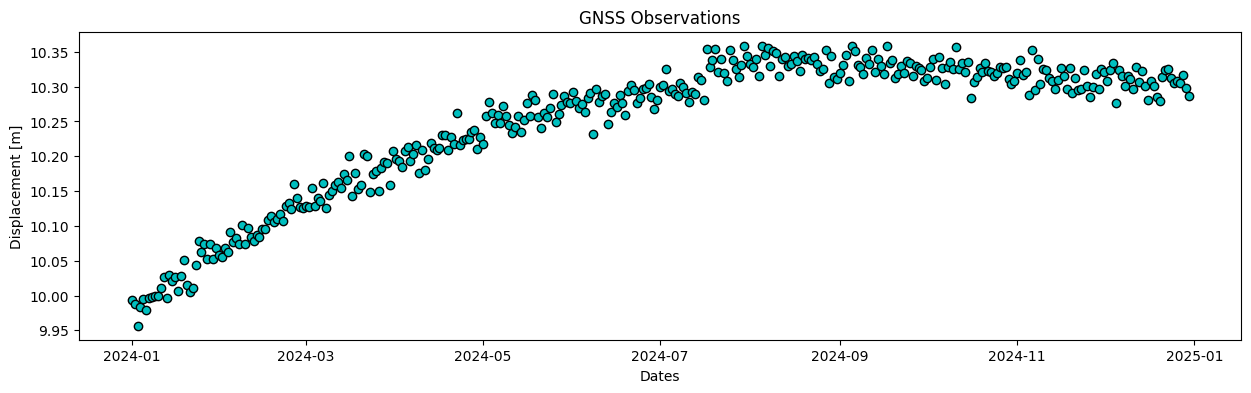

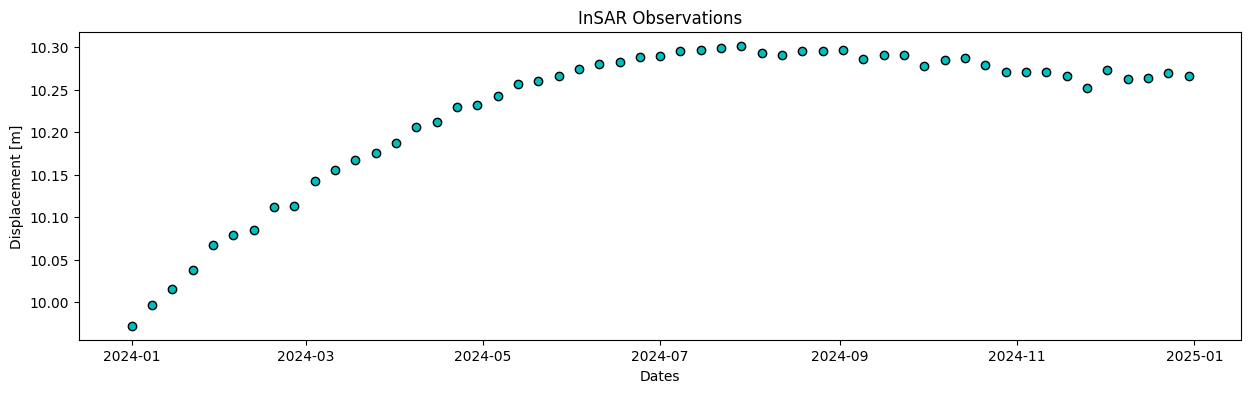

In [5]:
def print_summary(data):
    '''Summarize an array with simple print statements.'''
    print('Minimum =     ', data.min())
    print('Maximum =     ', data.max())
    print('Mean =        ', data.mean())
    print('Std dev =     ', data.std())
    print('Shape =       ', data.shape)
    print('First value = ', data[0])
    print('Last value =  ', data[-1])
    print('\n')
          
print('Summary for array: ')
print('------------------------------------------------')
print_summary(gnss_obs)
print_summary(insar_obs)

def plot_data(dates, data, label):
    plt.figure(figsize=(15,4))
    plt.plot(dates, data, 'co', mec='black')
    plt.title(label)
    plt.xlabel('Dates')
    plt.ylabel('Displacement [m]')
    plt.show()

plt.figure(figsize=(15,4))
plot_data(gnss_dates, gnss_obs, 'GNSS Observations')
plot_data(insar_dates, insar_obs, 'InSAR Observations')

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">

**Solution 1.1:**

The points obviously show uplift, the displacement shows a similar pattern for both datasets. The GNSS data is much noisier but has higher sampling rate. 
</p></div>



## Part 2: Constructing the design matrix and observation vector


As a starting point you assume that the surface at the observed location is subject to a linear increasing trend with a constant rate due to the injection by the powerplant, plus a seasonal effect driven by fluctuating precipitation, temperature and evapotranspiration. The observation equations that you will work with are:

$$
d = d_0 + vt + A\sin \left(\frac{2\pi t}{365} - \phi \right),
$$

where $d$ is the observed displacement, and $t$ is time (known), and the phase is assumed to be known: $\phi= \frac{\pi}{2}$.

The model has 3 unknowns:
1. $d_0$, the initial displacement at $t_0$
2. $v$ the displacement velocity
3. $A$ the amplitude of the seasonal variations

Your task is to construct the functional model that is defined as $\mathbb{E}(Y) = \mathrm{A x}$.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 2.1**

Construct the design matrix A and the observation vector $Y$ (for both the InSAR and GNSS observations) and show the first 5 rows of them.
    
</p>
</div>



In [6]:
A_gnss = np.ones((len(gnss_doy), 3))
A_gnss[:,1] = gnss_doy
A_gnss[:,2] = np.sin(2 * np.pi * gnss_doy / 365 - np.pi/2)
print ('The first 5 rows of the A matrix (GNSS) are:')
print (A_gnss[0:5, :])

y_gnss = gnss_obs
print ('\nThe first 5 observations [mm] of y_gnss are:')
print (y_gnss[0:5])

m_gnss = np.shape(A_gnss)[0]
n_gnss = np.shape(A_gnss)[1]
print(f'm = {m_gnss} and n = {n_gnss}')


A_insar = np.ones((len(insar_doy), 3))
A_insar[:,1] = insar_doy
A_insar[:,2] = np.sin(2 * np.pi * insar_doy / 365 - np.pi/2)
print ('The first 5 rows of the A matrix (InSAR) are:')
print (A_insar[0:5, :])
y_insar = insar_obs
print ('\nThe first 5 observations [mm] of y_insar are:')
print (y_insar[0:5])
m_insar = np.shape(A_insar)[0]
n_insar = np.shape(A_insar)[1]
print(f'm = {m_insar} and n = {n_insar}')

The first 5 rows of the A matrix (GNSS) are:
[[ 1.     1.    -1.   ]
 [ 1.     2.    -0.999]
 [ 1.     3.    -0.999]
 [ 1.     4.    -0.998]
 [ 1.     5.    -0.996]]

The first 5 observations [mm] of y_gnss are:
[9.993 9.987 9.957 9.983 9.996]
m = 365 and n = 3
The first 5 rows of the A matrix (InSAR) are:
[[ 1.     1.    -1.   ]
 [ 1.     8.    -0.991]
 [ 1.    15.    -0.967]
 [ 1.    22.    -0.929]
 [ 1.    29.    -0.878]]

The first 5 observations [mm] of y_insar are:
[ 9.972  9.997 10.016 10.037 10.067]
m = 53 and n = 3


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 2.2**

Answer the following questions:

1. What is the dimension of the vector with the observables $Y$?

2. What are the unknowns of the functional model?

3. What is the redundancy for this model?

*Hint: You may want to include these details in your report*

</div>



    

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 2.2:**
   
For InSAR:
<ol>
    <li>The number of observations is 53.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 50.</li>
</ol>
    
For GNSS:
<ol>
    <li>The number of observations is 365.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 362.</li>
</ol>  

</p>
</div>


## Part 3: Set-up stochastic model

We will use the Best Linear Unbiased Estimator (BLUE) to solve for the unknown parameters. Therefore we also need a stochastic model, which is defined as

$$
\mathbb{D}(Y) = \Sigma_{Y}.
$$

where $\Sigma_{Y}$ is the covariance matrix of the observable vector. 

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 3.1**

Construct the covariance matrix and assume that 
    
- $\sigma_\textrm{InSAR} = 5$ mm and $\sigma_\textrm{GNSS} = 15$ mm 
    
- the observables are normally distributed
    
- and that the observables are independent. 
    

</div>

In [7]:
std_gnss = 0.015 #m

Sigma_Y_gnss = np.identity(len(gnss_dates))*std_gnss**2

print ('\nSigma_Y (GNSS) is defined as:')
print (Sigma_Y_gnss)

std_insar = 0.005 #m
Sigma_Y_insar = np.identity(len(insar_dates))*std_insar**2

print ('\nSigma_Y (InSAR) is defined as:')
print (Sigma_Y_insar)


Sigma_Y (GNSS) is defined as:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Sigma_Y (InSAR) is defined as:
[[2.5e-05 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 2.5e-05 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 2.5e-05 ... 0.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 0.0e+00 0.0e+00 ... 2.5e-05 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 2.5e-05 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 2.5e-05]]


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 3.2**

Answer the following questions:

1. What information is contained in the covariance matrix?

2. How do you implement the assumption that all observations are independent?

3. What is the dimension of $\Sigma_{Y}$?

4. How do you create $\Sigma_{Y}$?

*Hint: You may want to include the information from your answers to questions 1-3 from this task in your report*

</div>



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 3.2:**

1. The covariance matrix contains information on the quality of the observations, where an entry on the diagonal represents the variance of one observation at a particular epoch. If there is an indication that for instance the quality for a particular time interval differs, different $\sigma$ values can be put in the stochastic model for these epochs. 

2. The off-diagonal in the matrix represents the correlation between observations at different epochs. Putting a zero value on the off-diagonal indicates zero correlation.

3. The dimension of the matrix is 53x53 for InSAR and 365x365 for GNSS.

4. See code.

</p></div>


## Part 4: Apply best linear unbiased estimation (BLUE)




<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 4.1**

Write a function to apply BLUE in the cell below and use the function to estimate the unknowns for the model using the data. Print the values for the estimated parameters
    

</div>

In [8]:
def BLUE(A, y, Sigma_Y):
    """Calculate the Best Linear Unbiased Estimator
    
    Write a docstring here (an explanation of your function).
    
    Function to calculate the Best Linear Unbiased Estimator
    
    Input:
        A = A matrix (mxn)
        y = vector with observations (mx1)
        Sigma_Y = Variance covariance matrix of the observations (mxm)
    
    Output:
        xhat = vector with the estimates (nx1)
        Sigma_Xhat = variance-covariance matrix of the unknown parameters (nxn)
    """
    
    Sigma_Xhat = np.linalg.inv(A.T @ np.linalg.inv(Sigma_Y) @ A)
    xhat = Sigma_Xhat @ A.T @ np.linalg.inv(Sigma_Y) @ y
    
    return xhat, Sigma_Xhat  

In [9]:
xhat_gnss, Sigma_Xhat_gnss = BLUE(A_gnss, y_gnss, Sigma_Y_gnss)

print ('The GNSS-estimated initial height is', np.round(xhat_gnss[0],3), 'm')
print ('The GNSS-estimated velocity is', np.round(xhat_gnss[1]*1000,3), 'mm/day')
print ('The GNSS-estimated velocity is', np.round(xhat_gnss[1]*365,3), 'm/year')
print ('The GNSS-estimated seasonal amplitude is', np.round(xhat_gnss[2],4), 'm')

x_hat_insar, Sigma_Xhat_insar = BLUE(A_insar, y_insar, Sigma_Y_insar)
print ('The InSAR-estimated initial height is', np.round(x_hat_insar[0],3), 'm')
print ('The InSAR-estimated velocity is', np.round(x_hat_insar[1]*1000,3), 'mm/day')
print ('The InSAR-estimated velocity is', np.round(x_hat_insar[1]*365,3), 'm/year')
print ('The InSAR-estimated seasonal amplitude is', np.round(x_hat_insar[2],4), 'm')

The GNSS-estimated initial height is 10.099 m
The GNSS-estimated velocity is 0.809 mm/day
The GNSS-estimated velocity is 0.295 m/year
The GNSS-estimated seasonal amplitude is 0.068 m
The InSAR-estimated initial height is 10.108 m
The InSAR-estimated velocity is 0.65 mm/day
The InSAR-estimated velocity is 0.237 m/year
The InSAR-estimated seasonal amplitude is 0.074 m



<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

**Task 4.2**

Do the values that you just estimated make sense? Explain, using quantitative results.    

</div>


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 4.2:**

See report

</p></div>



## Part 5: Evaluate the precision

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 5.1**:

What is the precision of the final estimates? Print the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.    

</div>

In [10]:
print ('Covariance matrix of estimated parameters (GNSS):')
print (Sigma_Xhat_gnss)
print ('\nThe standard deviation for the GNSS-estimated initial height is', 
       np.round(np.sqrt(Sigma_Xhat_gnss[0,0])*1000,3), 'mm')
print ('The standard deviation for the GNSS-estimated velocity is', 
       np.round(np.sqrt(Sigma_Xhat_gnss[1,1])*1000,3), 'mm/day')
print ('The standard deviation for the GNSS-estimated seasonal amplitude is', 
       np.round(np.sqrt(Sigma_Xhat_gnss[2,2]),3), 'm')

print ('\nCovariance matrix of estimated parameters (InSAR):')
print (Sigma_Xhat_insar)
print ('\nThe standard deviation for the InSAR-estimated initial height is', 
       np.round(np.sqrt(Sigma_Xhat_insar[0,0])*1000,3), 'mm')
print ('The standard deviation for the InSAR-estimated velocity is', 
       np.round(np.sqrt(Sigma_Xhat_insar[1,1])*1000,3), 'mm/day')
print ('The standard deviation for the InSAR-estimated seasonal amplitude is', 
       np.round(np.sqrt(Sigma_Xhat_insar[2,2]),3), 'm')

Covariance matrix of estimated parameters (GNSS):
[[ 2.476e-06 -1.016e-08 -1.016e-08]
 [-1.016e-08  5.553e-11  5.553e-11]
 [-1.016e-08  5.553e-11  1.233e-06]]

The standard deviation for the GNSS-estimated initial height is 1.574 mm
The standard deviation for the GNSS-estimated velocity is 0.007 mm/day
The standard deviation for the GNSS-estimated seasonal amplitude is 0.001 m

Covariance matrix of estimated parameters (InSAR):
[[ 1.849e-06 -7.528e-09  7.737e-09]
 [-7.528e-09  4.114e-11  3.982e-11]
 [ 7.737e-09  3.982e-11  9.289e-07]]

The standard deviation for the InSAR-estimated initial height is 1.36 mm
The standard deviation for the InSAR-estimated velocity is 0.006 mm/day
The standard deviation for the InSAR-estimated seasonal amplitude is 0.001 m



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 5.1:**

As shown above, the standard deviations of the estimated parameters are equal to the square root of the diagonal elements. Compared with the estimated values, the standard deviations seem quite small, meaning on the one hand that the uncertainty due to data quality is quite small and also that the estimated values are significant. 
    
The off-diagonal elements show the covariances between the estimated parameters, which are non-zeros since the estimates are all computed as function of the same vector of observations and the same model. 
</p></div>

## Part 6: Present and reflect on estimation results


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 6.1**

Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponding residuals ($\hat{\mathrm{\epsilon}}$). 
Visualize the results in two graphs and add the confidence bounds ($t$-versus-displacement and $t$-versus-residuals).

Also create a histogram of the residuals where you plot the normal distribution (which you can estimate from the histogram) as well and report the mean and sigma of the residuals. 

</div>

*Note that this Task gives you a lot of freedom for how you can set up your figures. For example, you could write a function to create the plots, then use it twice, once for each dataset. This Task might also take a significant amount of time, so plan accordingly.*

In [11]:
def plot_residual(date, y_obs, yhat, data_type, A,
                  Sigma_Xhat, Sigma_Y):

    ehat = y_obs - yhat

    # Compute the vc matrix for \hat{y}
    Sigma_Yhat = A @ Sigma_Xhat @ A.T
    std_yhat = np.sqrt(Sigma_Yhat.diagonal())

    # Compute the vc matrix for \hat{e}
    Sigma_ehat = Sigma_Y - Sigma_Yhat
    std_ehat = np.sqrt(Sigma_ehat.diagonal())
    
    # Compute residuals normalized by standard deviation
    ehat_normalized = ehat / std_ehat

    # Show the 99% confidence interval
    k99 = norm.ppf(1 - 0.5*0.01)
    confidence_interval_y = k99*std_yhat
    confidence_interval_res = k99*std_ehat

    # Plot original data and fitted model
    plt.figure(figsize = (15,5))
    plt.plot(date, y_obs, 'k+',  label = 'Observations')
    plt.plot(date, yhat,  label = 'Fitted model')
    plt.fill_between(date, (yhat - confidence_interval_y), 
                     (yhat + confidence_interval_y), facecolor='orange',
                     alpha=0.4, label = '99% Confidence Region')
    plt.legend()
    plt.ylabel(data_type + ' Displacement [m]')
    plt.xlabel('Time')
    plt.title(data_type + ' Observations and Fitted Model')


    # Plot time series of the residual
    plt.figure(figsize = (15,5))
    plt.plot(date, ehat, 'o', markeredgecolor='black', label='Residual')
    plt.plot(date,-confidence_interval_res, '--', color='orange', 
             label = '99% Confidence Region')
    plt.plot(date,confidence_interval_res, '--', color='orange')
    plt.legend()
    plt.ylabel(data_type + ' residual [m]')
    plt.xlabel('Time')
    plt.title(data_type + ' Residuals')

    # Plot histogram and normal distribution
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.hist(ehat_normalized, bins = 40, density=True,  edgecolor='black')
    x = np.linspace(np.min(ehat_normalized), np.max(ehat_normalized), num=100);
    plt.plot(x, norm.pdf(x, loc=0.0, scale = 1),
             linewidth=4.0)
    plt.title(data_type + ' Normalized Residuals Histogram')
    plt.xlabel('residual [-]')
    plt.ylabel('density')
    
    # Q-Q plot
    plt.subplot(122)
    sc.stats.probplot(ehat_normalized, dist="norm", plot=plt)
    plt.title(data_type + ' Normalized Residuals Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles') 
    
    print (f'The mean value of the {data_type} residuals is {np.mean(ehat):.3f} m')
    print (f'The standard deviation of the {data_type} residuals is {np.std(ehat):.3f} m')

    return ehat

The mean value of the GNSS residuals is -0.000 m
The standard deviation of the GNSS residuals is 0.021 m
The mean value of the InSAR residuals is -0.000 m
The standard deviation of the InSAR residuals is 0.016 m


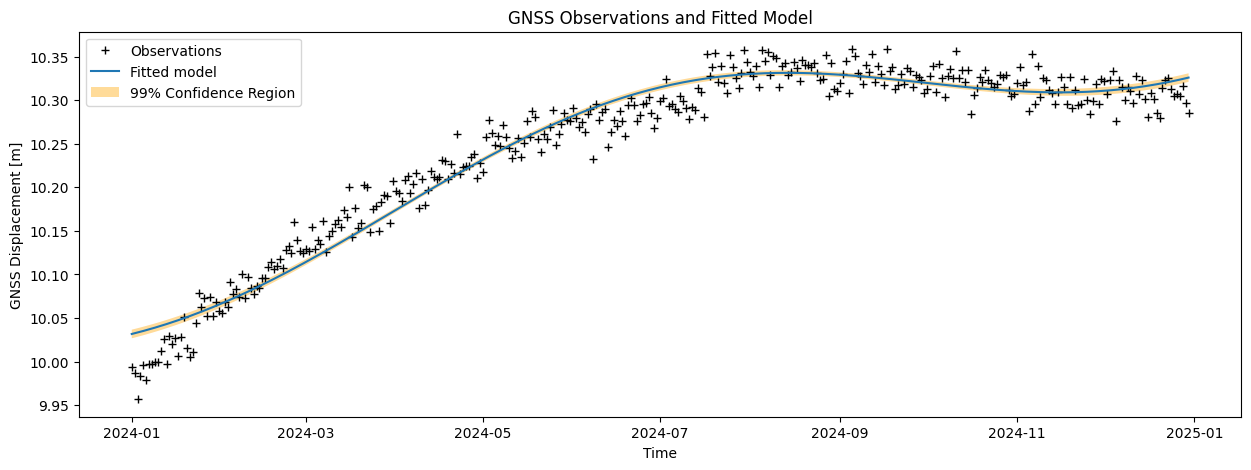

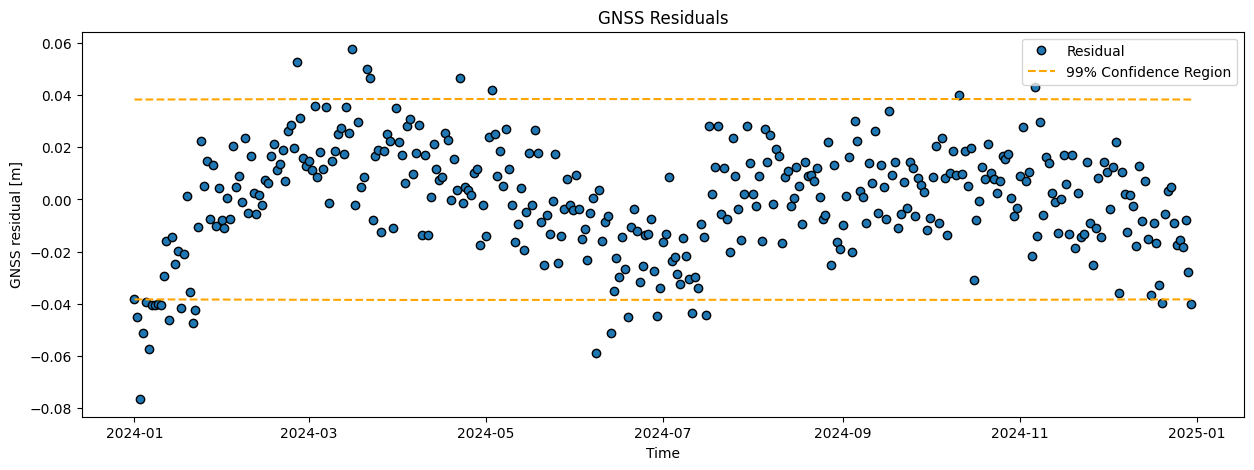

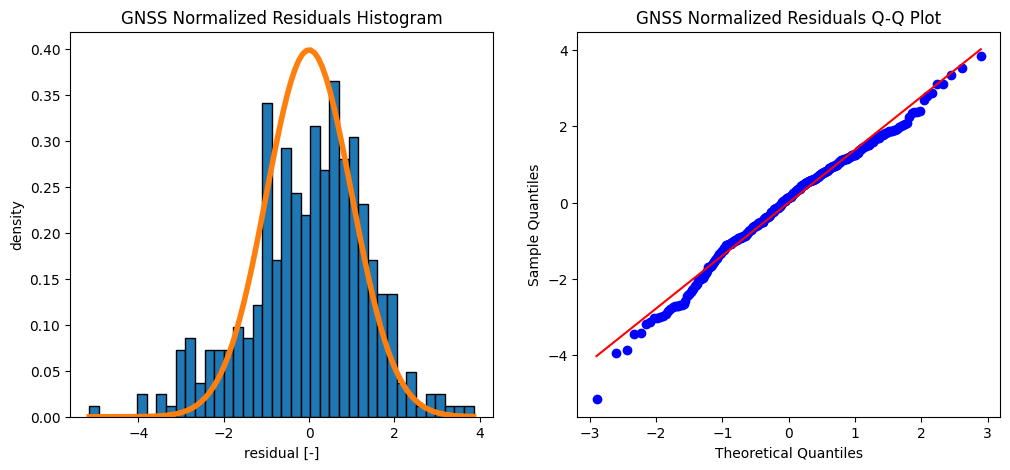

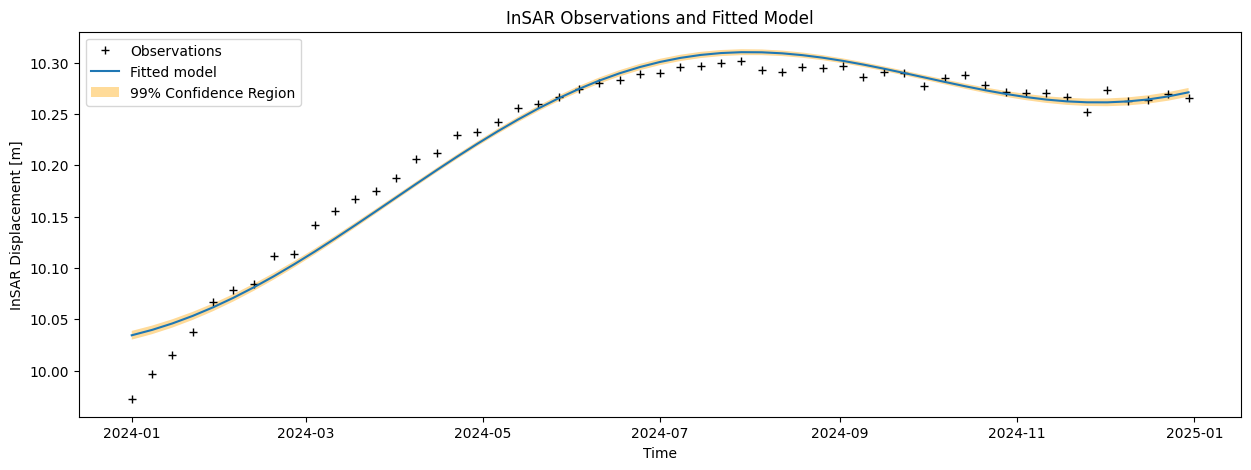

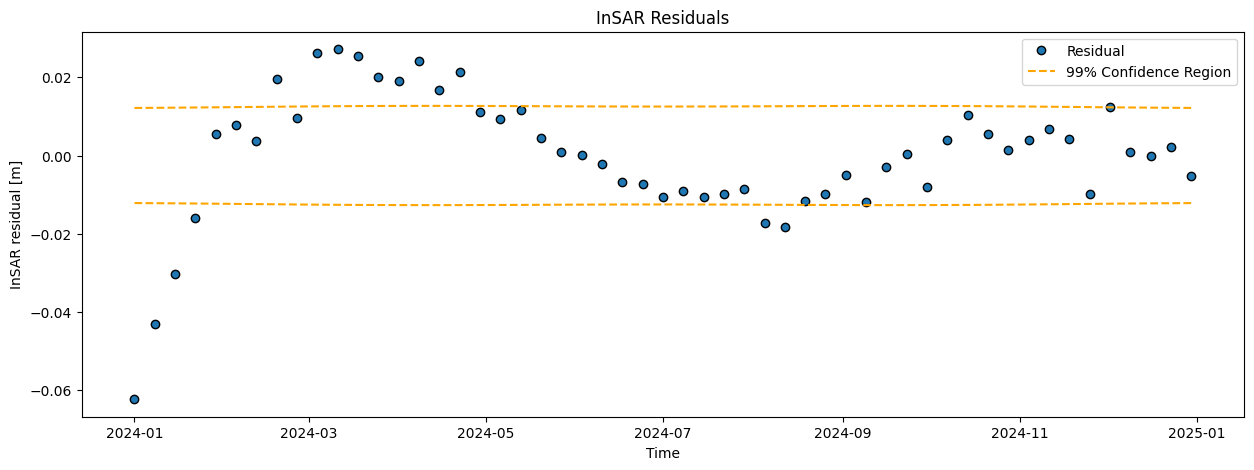

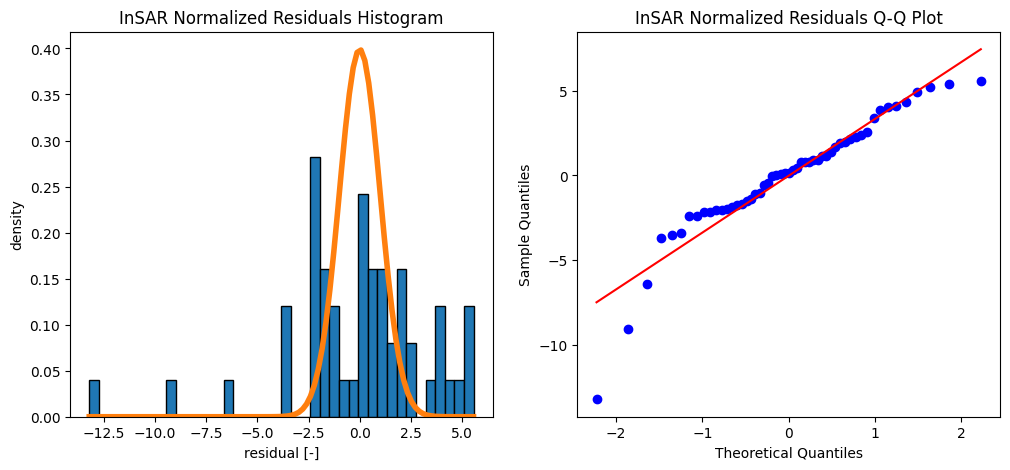

In [12]:
# this is the true model which was used to generate the data (Monte Carlo simulations)

# Residuals and plots for GNSS incl. confidence bounds
yhat_gnss = A_gnss @ xhat_gnss
ehat_gnss_1 = plot_residual(gnss_dates, y_gnss, yhat_gnss,
                             'GNSS', A_gnss, 
                             Sigma_Xhat_gnss, Sigma_Y_gnss)

# Residuals and plots for InSAR incl. confidence bounds
yhat_insar = A_insar @ x_hat_insar
ehat_insar_1 = plot_residual(insar_dates, y_insar, yhat_insar,
                             'InSAR', A_insar, 
                             Sigma_Xhat_insar, Sigma_Y_insar)



<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 6.2:**

Answer the following questions:

1. When you plot the residuals vs time, do you see any systematic effect? Give your interpretation for any discrepancy between observations and the model?
2. What is the mean value of the residuals?
3. What is the standard deviation of the residuals?
4. What can you conclude when you compare the histogram of the data with the computed normal distribution?
5. Did you use quantitative results in your answers?

*Hint: You may want to include these details in your report*

</div>




<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 6.2:**

**Note: here we plotted the true model as well, which you did not have.**
    

The mean value and standard deviation of the InSAR residuals is 0.0 m and 0.016 m.
The mean value and standard deviation of the GNSS residuals is 0.0 m and 0.021 m


The mean is thus close to zero, which may suggest a good fit. On the other hand, the residual plot clearly shows a systematic effect (pattern): the residuals are not 'randomly' fluctuaring around zero, and also the histogram and Q-Q plot show that the residuals are not normally distributed as expected. This indicates that the model is generally not good, and misses some important characteristics in the data. Perhaps we should consider adding a bit of complexity (next week!).
</p></div>



## Part 7: Compare results between different datasets


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">


**Task 7.1:**

Compare the results you found for the InSAR observations and the GNSS observations in the questions above. Discuss the differences between the results, including the precision. Be quantitative and try to explain the differences based on the differences of both datasets!
    
*Hint: You may want to include these details in your report*

</div>


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 7.1:**
    
Estimated parameters, hence fitted model, is different. Factors that have an impact:
    
- Precision of the observations
    
- Number of observations
    
Although the quality of the GNSS data is lower compared to InSAR (15 vs 5 mm), the precision of the estimated parameters is similar. Here we see the effect of 'more' data points: the much lower precision of the observations is somewhat compensated by the much higher number of observations.

Also, when reviewing the residuals for both datasets, it seems that the model that we use is maybe too simple since we miss part of the signal. 

</p></div>



## Part 8: How to deal with 2 datasets?

Data acquisition and processing comes with a price. Note that in a real situation you would not look at a time series of only one point. For Sentinel-1 data you may have to pay, collecting GNSS data at different locations also costs money. 


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

<b>Task 8.1</b>   
    
What would you advise the authorities in terms of monitoring: use GNSS, InSAR or both? And how would you change you processing strategy if you have both GNSS and InSAR data at your disposal?

*Hint: You may want to include these details in your report*

</p>
</div>




<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
</p>

**Solution 8.1:**

Use the observations together (i.e., estimate the unknown parameters using the GNSS and InSAR observations at the same time, which would result in 791 observations). With BLUE we would of course apply proper weights, taking into account the different precisions.

</p></div>



> By Lina Hagenah and Sandra Verhagen, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).